# MNIST classification with Qiskit

In [24]:
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit_aer import Aer
from qiskit.visualization import array_to_latex
from qiskit.quantum_info.operators import Operator, Pauli

import numpy as np
import matplotlib.pyplot as plt
from sympy.physics.quantum.qubit import matrix_to_qubit
from scipy.optimize import minimize
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [2]:
def sim_state(qc, disp=True):
    '''
    量子回路qcの量子状態を取得する。

    Args:
        qc (QuantumCircuit): 量子回路
        disp (Bool): Trueにするとketベクトルの線型結合の形で量子状態表記を得る。
    '''
    sim = Aer.get_backend('statevector_simulator')
    qc = transpile(qc, backend=sim)
    res = sim.run(qc).result()
    state = res.data()['statevector']
    if disp:
        ket = matrix_to_qubit(np.array(state)[:, np.newaxis])
        print(ket)
    return state

In [3]:
def mag_exp(qc, n):
    '''
    引数に与えられた期待値を計算する。

    Args:
        qc (QuantumCircuit): 量子回路
        n (int): qubit数

    Returns:
        y (float): 期待値
    '''
    state = sim_state(qc, disp=False)
    op = Operator(np.zeros([2**n, 2**n]))
    for k in range(n):
        op_str = ''
        for l in range(n):
            if l == k:
                op_str += 'Z'
            else:
                op_str += 'I'
        op += Operator(Pauli(op_str))
        
    y = state.expectation_value(op)/n
    return y

In [4]:
def U_in(x, n):
    '''
    Args:
        x データ。-1〜1に規格化された
    '''
    qc = QuantumCircuit()
    qr = QuantumRegister(n)
    qc.add_register(qr)

    angle = np.arcsin(x)
    qc.rx(angle, qr)
    
    U_in = qc.to_gate()
    U_in.name = 'U_in'

    return U_in

In [ ]:
def U_in_for_MNIST(image_data, n, encoding_method=None):
    '''
    MNISTの画像データのインプット

    Args:    
        image_data (): 1画像のデータ。
        n (int): qubit数
        encoding_method (str): エンコーディング方法の指定。
                                "amplitude", "basis", "angle"のいずれかを指定すること。
    '''
    qc = QuantumCircuit()
    qr = QuantumRegister(n)
    qc.add_register(qr)
    
    # データを正規化
    norm = np.linalg.norm(image_data)
    image_data = image_data / norm
    
    # 量子状態にエンコード(amplitude encoding)
    qc.initialize(image_data.tolist(), range(n))
    
    U_in = qc.to_gate()
    U_in.name = 'U_in'
    
    return U_in

In [5]:
def QCLinput(x, n):
    '''
    量子回路を作るための関数
    '''
    qc = QuantumCircuit()
    qr = QuantumRegister(n)
    qc.add_register(qr)
    qc.append(U_in(x, n), qr)
    return qc

In [6]:
def U_rot(n, params):
    '''
    Args:
        n (int):
        params (list): rx: 0, 1, 2, ..., n-1
                       ry: n, n+1, n+2, ..., n+n-1
                       rz: 2n, 2n+1, 2n+2, ..., 2n+n-1
    '''
    qc = QuantumCircuit()
    qr = QuantumRegister(n)
    qc.add_register(qr)
    for k in range(n):
        qc.rx(params[k], qr[k])
        qc.ry(params[n+k], qr[k])
        qc.rz(params[2*n+k], qr[k])
    Urot = qc.to_gate()
    Urot.name = 'Urot'
    return Urot

In [7]:
def U_ent(n):
    '''
    entanglement
    '''
    qc = QuantumCircuit()
    qr = QuantumRegister(n)
    qc.add_register(qr)

    if n > 1:
        for k in range(n-1):
            qc.cz(qr[k], qr[k+1])
        qc.cz(qr[n-1], qr[0])

    Uent = qc.to_gate()
    Uent.name = 'U_ent'
    return Uent    

In [26]:
# MNISTデータの準備
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [33]:
# MNISTデータ確認
print(X.shape)  # (70000, 784)
print(y.shape)  # (70000,)
print(X_train.shape, X_test.shape) # (56000, 784) (14000, 784)
print(y_train.shape, y_test.shape) # (56000,) (14000,)

display(X_train)
display(y_train)

(70000, 784)
(70000,)
(56000, 784) (14000, 784)
(56000,) (14000,)


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
47339,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67456,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12308,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32557,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
664,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37194,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6265,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
54886,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
860,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


47339    5
67456    4
12308    8
32557    0
664      2
        ..
37194    6
6265     6
54886    1
860      0
15795    0
Name: class, Length: 56000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [ ]:
# MNIST用データでQNN作成
# まずは、ランダムに生成したparamをそのまま用いたQNNではどのような出力をするかの実験

n = 3
depth = 3
params = np.random.rand(3*n*depth)*2*np.pi

for i in range(len(X_train.columns)):
    # 入力層
    image_data = np.array(X_train.iloc[i, :])
    qc = U_in_for_MNIST(image_data, n)
    qr = qc.qubits
    
    # 中間層
    for k in range(depth):
        qc.append(U_ent(n), qr)
        qc.append(U_rot(n, params[k*3*n:(k+1)*3*n]), qr)
    # 出力層
    y = mag_exp(qc, n)
    y_series.append(y)


In [8]:
# 回帰用データでQNN作成
# まずは、ランダムに生成したparamをそのまま用いたQNNではどのような出力をするかの実験

n = 3
x_series = np.linspace(-1, 1, 100)
y_series = []
depth = 3
params = np.random.rand(3*n*depth)*2*np.pi

for x in x_series:
    # 入力層
    qc = QCLinput(x, n)
    qr = qc.qubits
    # 中間層
    for k in range(depth):
        qc.append(U_ent(n), qr)
        qc.append(U_rot(n, params[k*3*n:(k+1)*3*n]), qr)
    # 出力層
    y = mag_exp(qc, n)
    y_series.append(y)

In [9]:
qc.draw()

┌───────┐┌────────┐┌───────┐┌────────┐┌───────┐┌────────┐┌───────┐
q793_0: ┤0      ├┤0       ├┤0      ├┤0       ├┤0      ├┤0       ├┤0      ├
        │       ││        ││       ││        ││       ││        ││       │
q793_1: ┤1      ├┤1       ├┤1      ├┤1       ├┤1      ├┤1       ├┤1      ├
        │       ││        ││       ││        ││       ││        ││       │
q793_2: ┤2      ├┤2       ├┤2      ├┤2       ├┤2      ├┤2       ├┤2      ├
        │       ││        ││       ││        ││       ││        ││       │
q793_3: ┤3      ├┤3       ├┤3      ├┤3       ├┤3      ├┤3       ├┤3      ├
        │       ││        ││       ││        ││       ││        ││       │
q793_4: ┤4 U_in ├┤4 U_ent ├┤4 Urot ├┤4 U_ent ├┤4 Urot ├┤4 U_ent ├┤4 Urot ├
        │       ││        ││       ││        ││       ││        ││       │
q793_5: ┤5      ├┤5       ├┤5      ├┤5       ├┤5      ├┤5       ├┤5      ├
        │       ││        ││       ││        ││       ││        ││       │
q793_6: ┤6      ├┤6       ├┤6      ├┤6       ├┤6      ├┤6       ├┤6      ├
        │       ││        ││       ││        ││       ││        ││       │
q793_7: ┤7      ├┤7       ├┤7      ├┤7       ├┤7      ├┤7       ├┤7      ├
        │       ││        ││       ││        ││       ││        ││       │
q793_8: ┤8      ├┤8       ├┤8      ├┤8       ├┤8      ├┤8       ├┤8      ├
        └───────┘└────────┘└───────┘└────────┘└───────┘└────────┘└───────┘

/home/user/anaconda3/envs/quantum_q_p/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/user/anaconda3/envs/quantum_q_p/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


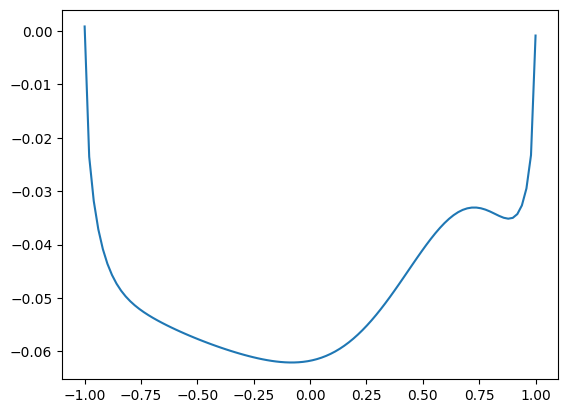

In [10]:
# plt.plot(x_series, y_series)
# plt.show()

#### 学習

In [11]:
# 真値
func = lambda x: 0.5*x**3

In [12]:
ntrain = 10

# 訓練データ（-1〜1）
xtrain = 2*np.random.rand(ntrain)-1
# 教師データ
ytrain = func(xtrain)

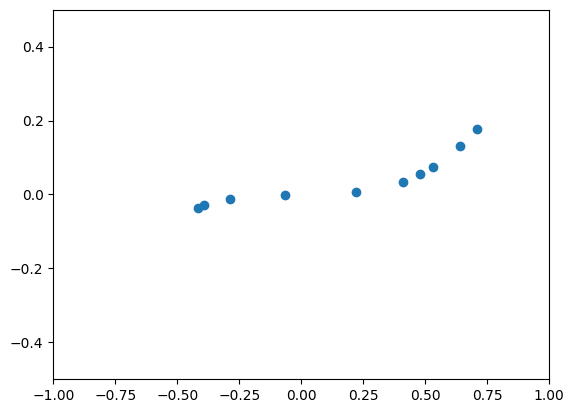

In [13]:
plt.scatter(xtrain, ytrain)
plt.xlim([-1, 1])
plt.ylim([-0.5, 0.5])
plt.show()

In [14]:
def cost_func(params):
    '''
    コスト関数
    '''
    cost_total = 0
    for k in range(ntrain):
        x = xtrain[k]
        qc = QCLinput(x, n)
        qr = qc.qubits
        for d in range(depth):
            qc.append(U_ent(n), qr)
            qc.append(U_rot(n, params[d*3*n:(d+1)*3*n]), qr)
        y = mag_exp(qc, n)
        cost = 0.5*(ytrain[k]-y)**2
        cost_total += cost
    cost_total /= ntrain
    return cost_total

In [15]:
# 勾配を使わない、探索的な最適化方法
result =  minimize(cost_func, params, method='COBYLA', options={'maxiter': 50})

/home/user/anaconda3/envs/quantum_q_p/lib/python3.9/site-packages/scipy/optimize/_cobyla_py.py:293: ComplexWarning: Casting complex values to real discards the imaginary part
  xopt, info = cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,
/home/user/anaconda3/envs/quantum_q_p/lib/python3.9/site-packages/scipy/optimize/_cobyla_py.py:293: ComplexWarning: Casting complex values to real discards the imaginary part
  xopt, info = cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,
/home/user/anaconda3/envs/quantum_q_p/lib/python3.9/site-packages/scipy/optimize/_cobyla_py.py:293: ComplexWarning: Casting complex values to real discards the imaginary part
  xopt, info = cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,
/home/user/anaconda3/envs/quantum_q_p/lib/python3.9/site-packages/scipy/optimize/_cobyla_py.py:293: ComplexWarning: Casting complex values to real discards the imaginary part
  xopt, info = cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,
/hom

In [16]:
# 0に近いほうが良い。
result.fun

0.0004614478464436288

In [17]:
result.x

array([4.36354258, 4.79130364, 3.91525761, 4.94285955, 6.25196627,
       3.01956195, 1.01023016, 2.11680775, 2.10153823, 0.98390219,
       4.20426361, 0.75076148, 3.36908837, 3.73693315, 4.93483173,
       0.68396971, 4.08798487, 3.28164037, 2.13913945, 4.91682674,
       5.38274871, 4.04725593, 0.11367164, 1.82431867, 4.18049511,
       3.80977391, 4.39624871, 1.29922192, 3.6652596 , 2.28879569,
       3.16313041, 3.88281301, 2.31435791, 5.78831333, 1.69746214,
       5.56594319, 5.84130469, 1.85904616, 5.89488172, 0.67707999,
       0.20835205, 3.55306867, 4.72396614, 2.2567565 , 3.08506418,
       0.13735033, 5.06917994, 2.9808773 , 1.37287413, 5.65013207,
       1.07051359, 6.24408858, 3.27423424, 1.34980203, 0.30654926,
       1.54887634, 6.00356024, 2.14080887, 4.03361611, 2.3251352 ,
       5.77913693, 1.73245989, 3.70339505, 4.34209933, 1.4361405 ,
       5.30859778, 3.39297204, 2.02374225, 0.57884379, 5.93376529,
       2.42116418, 4.31979736, 1.83218005, 4.31406616, 4.74022

In [18]:
# 学習済みのパラメータを使って推論
y_series = []
params = result.x

for x in x_series:
    qc = QCLinput(x, n)
    qr = qc.qubits
    for d in range(depth):
        qc.append(U_ent(n), qr)
        qc.append(U_rot(n, params[d*3*n:(d+1)*3*n]), qr)
    y = mag_exp(qc, n)
    y_series.append(y)

In [19]:
y_correct = func(x_series)

/home/user/anaconda3/envs/quantum_q_p/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/user/anaconda3/envs/quantum_q_p/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


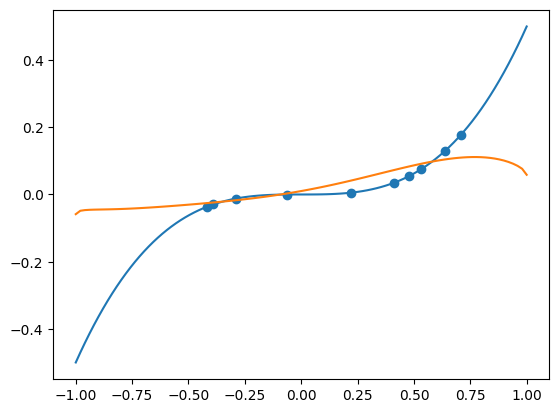

In [20]:
plt.scatter(xtrain, ytrain)
plt.plot(x_series, y_correct)
plt.plot(x_series, y_series)
plt.show()

---
#### MNISTの学習 及び推論

In [ ]:
def cost_func_for_MNIST(params):
    '''
    コスト関数
    '''
    cost_total = 0
    for k in range(len(X_train.columns)):
        x = xtrain[k]
        qc = QCLinput(x, n)
        qr = qc.qubits
        for d in range(depth):
            qc.append(U_ent(n), qr)
            qc.append(U_rot(n, params[d*3*n:(d+1)*3*n]), qr)
        y = mag_exp(qc, n)
        cost = 0.5*(ytrain[k]-y)**2
        cost_total += cost
    cost_total /= ntrain
    return cost_total